# 背景介绍

IEEE-CIS欺诈检测比赛，从客户的交易中发现欺诈行为，一个典型的二分类的比赛，场景和信用卡评分这类应用十分接近，很有意义的一个比赛。并且数据的数量和质量都很好，坏客户的数量达到了20000+。好坏样本比例大概是29:1
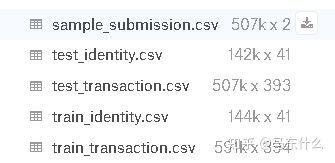
比赛数据集很小，仅一张副表。各个字段官方的discuss中也给出了解释：

## 交易表（transaction表）*
TransactionID:主键
TransactionDT：来自给定参考日期时间的timedelta（不是实际时间戳）
TransactionAMT：以美元计算的交易付款金额
ProductCD：产品代码，每笔交易的产品类型
card1 ~ card6：支付卡信息，如卡类型，卡类别，发行银行，国家/地区等。
addr1~add2：支付卡的地址
dist~dist2：距离
P_emaildomain 和 R_emaildomain：购买者和收件人电子邮件域
C1-C14：计数，例如发现与支付卡相关联的地址数等，实际含义被掩盖。
D1-D15：timedelta，时间间隔，例如当前交易和上次交易之间的间隔天数等。
M1-M9：匹配，例如卡片上的姓名和地址等。
Vxxx：Vesta设计了丰富的特征，包括排名，计数和其他实体关系。
类别特征：
ProductCD
card1 - card6
addr1，addr2
P emaildomain R emaildomain
M1 - M9

## 身份表（identity表）*
TransactionID:主键
该表中的变量是与交易相关的身份信息 - 网络连接信息（IP，ISP，代理等）和数字签名（UA /浏览器/操作系统/版本等）。
它们由Vesta的欺诈保护系统和数字安全合作伙伴收集。
（字段名称被屏蔽，并且不会提供成对字典用于隐私保护和合同协议）

DeviceType 用户使用的设备类型
DeviceInfo  用户使用的设备信息
id 1 ~ id 38  网络连接、数字签名等相关特征
类别特征：
DeviceType 
DeviceInfo  
id 12 ~ id 38  

关于每个字段的含义具体可以参考：
https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203
非常难得这么详细的介绍，比赛最大的得分点都来源于此

# 整体的思路

1、看比赛的背景介绍，比赛的评分方式，主办方对所有字段含义的解释（如果是匿名赛就更复杂了，好在这次算是半匿名，只有部分特征是含义不清的），查看过去相似的比赛以及获奖选手的思路分享与开源代码， 很多时候别人发布过的代码可以直接快速的复用；
2、eda 数据探索，通过可视化、计算统计值等寻找数据中的异常之处，并且在这个过程中进一步熟悉手头的数据，在这个过程中可以参考一些开源的kernel，但是尽量自己思考，而不是直接抄袭，参加比赛的主要目的是学习与自我提升，要建立起自己的思维框架来解决问题；
3、性能优化，包括了原始数据的数据类型的优化以降低内存占用与存储、一些常用的函数的定义避免过于冗余的代码、一些运行时间很久的函数的性能优化以提高试验的速度与效率，文件快速的读取与存储、原始数据的采样等等；
4、建立一个baseline，后续在这个baseline上进行深入的调整；
5、确定一个好的cv策略（对于无序的问题，可能cv就是简单的kfold或者stratifiedkfold，但是对于时序相关的问题，cv的选择还是比较重要的，如何尽量降低时间穿越的影响是一件比较重要的事）；
6、根据模型的表现对症下药找到问题所在然后实施对应的特征工程方法衍生新的特征、转换原始特征或者进行特征选择；
7、感觉特征工程实在进行不下去了，使用stacking等集成方法与技巧来上分

# 读取数据

In [1]:
import pandas as pd
import gc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn-colorblind')
%matplotlib inline
from data_exploration import explore

In [2]:
train_transaction = pd.read_csv('./data/train_transaction.csv')
train_transaction.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
test_trainsaction=pd.read_csv('./data/test_transaction.csv')

上表为我们的主表，需要注意的是，这里的TransactionID代表的是交易单号而不是用户的unique id，一个用户可能对应多条交易单号；
先简单概览一下数据大概的情况

In [4]:
train_identity = pd.read_csv('./data/train_identity.csv')
train_identity.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,...,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [5]:
test_identity = pd.read_csv('./data/test_identity.csv')

上表为我们的附属表，主要是表示每一个单号所对应的设备信息等信息

# 获取每一个特征的类型

In [6]:
str_var_list, num_var_list, all_var_list = explore.get_dtypes(data=train_transaction)
print(str_var_list) # string type
print(num_var_list) # numeric type
print(all_var_list) # all

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', '

In [7]:
str_var_list, num_var_list, all_var_list = explore.get_dtypes(data=train_identity)
print(str_var_list) # string type
print(num_var_list) # numeric type
print(all_var_list) # all

['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']
['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']


 由于使用了csv的格式存储，一些以int或者float形式存储的类别特征读取为dataframe后会被判定为数值特征，所以我们需要根据官方给的数据描述来指定特征的格式，只需要指定类别特征是哪些列就可以了

In [8]:
cat_train_transaction=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', \
      'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [9]:
cat_train_identity=['id_'+str(item) for item in range(12,39)]+['DeviceType', 'DeviceInfo']

# 表合并
一个特征衍生的小方案，附表增加'had_id'特征则与主表合并后可表示主表样本是否存在于附表

In [10]:
train_identity['had_id']=1
test_identity['had_id']=1
X_train=train_transaction.merge(train_identity,on='TransactionID',how='left',left_index=True, right_index=True)
X_test=test_trainsaction.merge(test_identity,on='TransactionID',how='left',left_index=True, right_index=True)

In [11]:
gc.enable()
del test_identity,test_trainsaction,train_identity,train_transaction
gc.collect()

0

In [12]:
cat=cat_train_transaction+cat_train_identity

# 统计性描述

In [13]:
explore.describe(data=X_train,output_path=r'./output/')

result saved at: ./output/describe.csv


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,had_id
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.000000,588975.000000,588963,586281.000000,...,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666,144233.0
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,NaN,260,4,2,2,2,2,2,1786,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows,NaN
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,NaN,16874,60011,77814,134066,110452,73922,85165,47722,NaN
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,NaN,9898.734658,362.555488,153.194925,NaN,199.278897,...,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,1.704744e+05,0.183755,4.617224e+06,239.162522,NaN,4901.170153,157.793246,11.336444,NaN,41.244453,...,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.251000,NaN,1000.000000,100.000000,100.000000,NaN,100.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,NaN,6019.000000,214.000000,150.000000,NaN,166.000000,...,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,NaN,9678.000000,361.000000,150.000000,NaN,226.000000,...,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.000000,150.000000,NaN,226.000000,...,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [14]:
explore.describe(data=X_test,output_path=r'./output/')

result saved at: ./output/describe.csv


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,had_id
count,5.066910e+05,5.066910e+05,506691.000000,506691,506691.000000,498037.000000,503689.000000,503605,502144.000000,503684,...,70671.000000,70671,72175,136977,136977,136977,136977,136931,115057,141907.0
unique,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,3,...,NaN,390,2,2,2,2,2,2,2226,NaN
top,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,debit,...,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows,NaN
freq,NaN,NaN,NaN,360987,NaN,NaN,NaN,334882,NaN,385021,...,NaN,16868,72174,71650,133287,104697,95058,74403,44988,NaN
mean,3.916894e+06,2.692994e+07,134.725568,NaN,9957.222175,363.735379,153.543409,NaN,200.162975,NaN,...,26.217939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,1.462692e+05,4.756507e+06,245.779822,NaN,4884.960969,158.688653,12.443013,NaN,40.562461,NaN,...,3.601046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,3.663549e+06,1.840322e+07,0.018000,NaN,1001.000000,100.000000,100.000000,NaN,100.000000,NaN,...,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,3.790222e+06,2.277154e+07,40.000000,NaN,6019.000000,207.000000,150.000000,NaN,166.000000,NaN,...,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,3.916894e+06,2.720466e+07,67.950000,NaN,9803.000000,369.000000,150.000000,NaN,226.000000,NaN,...,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,4.043566e+06,3.134856e+07,125.000000,NaN,14276.000000,512.000000,150.000000,NaN,226.000000,NaN,...,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# EDA可视化数据探索
数据探索的目的：
1、找异常，并且将异常表示成模型能够识别的形式
2、熟悉你手中的数据，了解数据的整体情况

主要方法：
1、训练集和测试集的分布差异可视化 ；
2、对于二分类问题，不同类别分布差异可视化
3、其它等

主要手段：
1、boxplot图
2、hist图
3、一些统计特征

## TransactionDT 
结合数据描述中关于这个特征的描述，很容易可以判断出来这是一个时间戳格式的数据，这里我们得到了用于指示交易时间的一个特征，该怎么用？
1、将这个特征作为X轴，与其它连续特征进行plot从而查看哪些特征也是随着时间变化的；
2、设法将时间戳转化为日期然后提取出年月日等信息从而将时间序列特征；
3、时序相关特征与时间戳特征进行某种运算（相减较常见）从而去除一定的时间相关性
3、更加复杂的时间序列特征的提取可见tsfresh，不过这里没有用户的uid所以无法使用tsfresh进行特征的暴力提取，tsfresh可见 
https://zhuanlan.zhihu.com/p/102186988
4、更多时间序列相关的方法可见： https://zhuanlan.zhihu.com/p/67832773

不过这个比赛倒是和时间序列的关系并不大

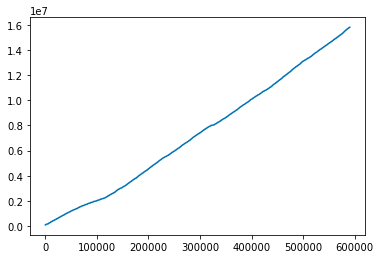

In [15]:
plt.plot(X_train.TransactionDT)

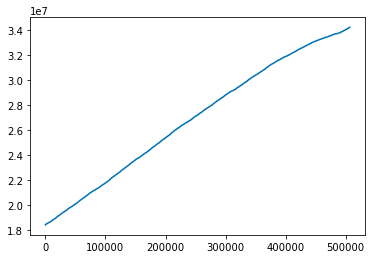

In [16]:
plt.plot(X_test.TransactionDT)

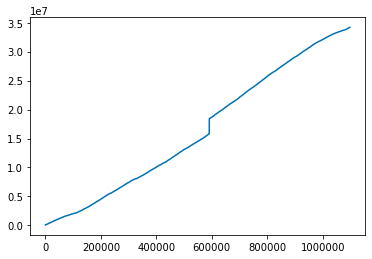

In [17]:
plt.plot(X_train.TransactionDT.values.tolist()+X_test.TransactionDT.values.tolist())

这里我们可以使用TransactionDT作为X轴，其它连续特征作为y轴从而观察是否有随着时间规律性变动的特征；同时也可以提取出TransactionDT的周期性特征，比如设置一个start_date，然后提取出年月日等特征，这里暂时先记录再当前目录的记事本“特征衍生方案”下；

## TransactionAmt 
根据下面的图可以看到，这个特征显然和时间没什么关系，但是存在一些异常大的值

{'whiskers': [<matplotlib.lines.Line2D at 0x2065079a828>,
 'caps': [<matplotlib.lines.Line2D at 0x205ea55e358>,
 'boxes': [<matplotlib.lines.Line2D at 0x205ea558978>],
 'medians': [<matplotlib.lines.Line2D at 0x205ea55e9e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x205ea55ed30>],
 'means': []}

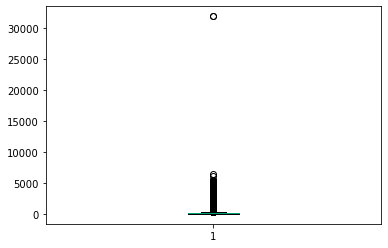

In [18]:
plt.boxplot(X_train.TransactionAmt)

{'whiskers': [<matplotlib.lines.Line2D at 0x205ea895160>,
 'caps': [<matplotlib.lines.Line2D at 0x205ea67dc18>,
 'boxes': [<matplotlib.lines.Line2D at 0x205ea67d278>],
 'medians': [<matplotlib.lines.Line2D at 0x205ea6702e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x205ea670630>],
 'means': []}

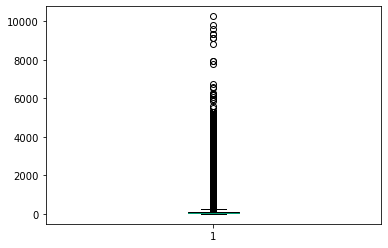

In [19]:
plt.boxplot(X_test.TransactionAmt)

{'whiskers': [<matplotlib.lines.Line2D at 0x205ea740be0>,
 'caps': [<matplotlib.lines.Line2D at 0x205ea7712b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x205ea7408d0>],
 'medians': [<matplotlib.lines.Line2D at 0x205ea771940>],
 'fliers': [<matplotlib.lines.Line2D at 0x205ea771c88>],
 'means': []}

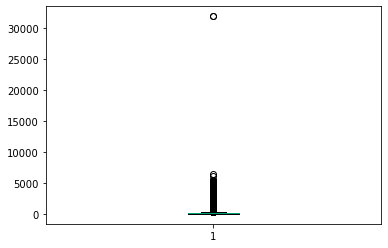

In [20]:
plt.boxplot(X_train.loc[X_train.isFraud==0,'TransactionAmt'])

{'whiskers': [<matplotlib.lines.Line2D at 0x205ea4934a8>,
 'caps': [<matplotlib.lines.Line2D at 0x205ea493b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x205ea493160>],
 'medians': [<matplotlib.lines.Line2D at 0x205ea4b6208>],
 'fliers': [<matplotlib.lines.Line2D at 0x205ea4b6550>],
 'means': []}

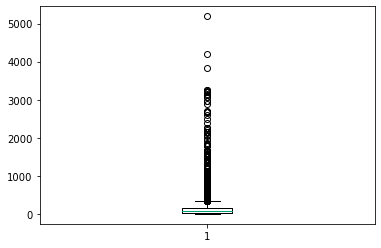

In [21]:
plt.boxplot(X_train.loc[X_train.isFraud==1,'TransactionAmt'])

([array([3.12999855e-04, 1.11345017e-07, 5.30214365e-10, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.06042873e-09]),
  array([3.12903304e-04, 2.00835730e-07, 6.79751703e-09, 1.85386828e-09,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00])],
 array([1.80000000e-02, 3.19375530e+03, 6.38749260e+03, 9.58122990e+03,
        1.27749672e+04, 1.59687045e+04, 1.91624418e+04, 2.23561791e+04,
        2.55499164e+04, 2.87436537e+04, 3.19373910e+04]),
 <a list of 2 Lists of Patches objects>)

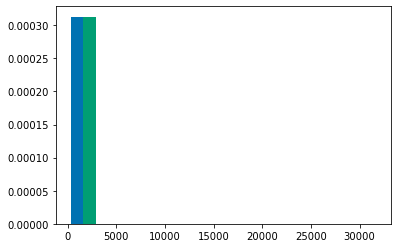

In [22]:
plt.hist([X_train.TransactionAmt,X_test.TransactionAmt],density=True)

([array([4.16369303e-03, 5.66597678e-04, 1.48860501e-04, 4.45791363e-05,
         2.91671764e-05, 2.01018175e-05, 8.53010345e-06, 7.96086348e-06,
         6.03224447e-06, 4.47745470e-06]),
  array([4.16458040e-03, 5.69490384e-04, 1.48042148e-04, 4.48711601e-05,
         2.50648656e-05, 1.98855196e-05, 8.43748143e-06, 7.82348630e-06,
         5.97159777e-06, 5.83295371e-06])],
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 2 Lists of Patches objects>)

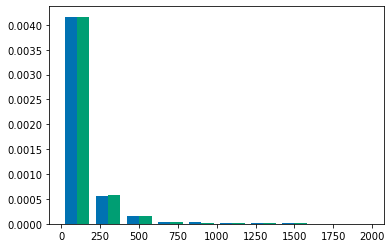

In [23]:
plt.hist([X_train.TransactionAmt,X_test.TransactionAmt],range=(0,2000),density=True)

([array([3.13001341e-04, 1.12086425e-07, 5.49443258e-10, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.09888652e-09]),
  array([3.13024155e-04, 9.09205078e-08, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00])],
 array([2.5100000e-01, 3.1939650e+03, 6.3876790e+03, 9.5813930e+03,
        1.2775107e+04, 1.5968821e+04, 1.9162535e+04, 2.2356249e+04,
        2.5549963e+04, 2.8743677e+04, 3.1937391e+04]),
 <a list of 2 Lists of Patches objects>)

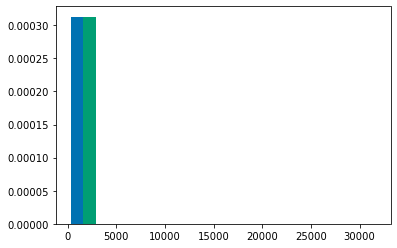

In [24]:
plt.hist([X_train.loc[X_train.isFraud==0,'TransactionAmt'],X_train.loc[X_train.isFraud==1,'TransactionAmt']],density=True)

([array([4.17315715e-03, 5.62510235e-04, 1.45470106e-04, 4.44281657e-05,
         2.68981463e-05, 2.03475012e-05, 8.53168698e-06, 8.02982304e-06,
         6.05758581e-06, 4.56960325e-06]),
  array([3.90305999e-03, 6.79162019e-04, 2.42228796e-04, 4.87367247e-05,
         9.16541390e-05, 1.33359197e-05, 8.48649435e-06, 6.06178168e-06,
         5.33436788e-06, 1.93977014e-06])],
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 2 Lists of Patches objects>)

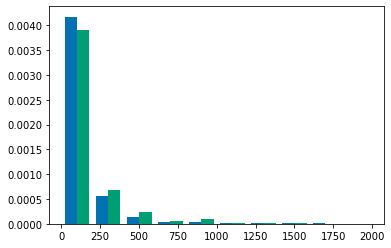

In [25]:
plt.hist([X_train.loc[X_train.isFraud==0,'TransactionAmt'],X_train.loc[X_train.isFraud==1,'TransactionAmt']],range=(0,2000),density=True)

训练与测试集上的分布差异并不大，好坏客户的分布差异相对大一些，从上图可以看出，欺诈用户相对来说更偏向于大额交易一点点，在金额较高的交易中相对占比要比普通用户高

## productCD

In [26]:
X_train.ProductCD.value_counts(1)

W    0.744522
C    0.116028
R    0.063838
H    0.055922
S    0.019690
Name: ProductCD, dtype: float64

In [27]:
X_test.ProductCD.value_counts(1)

W    0.712440
C    0.136703
R    0.070353
H    0.057970
S    0.022534
Name: ProductCD, dtype: float64

([array([1.86130491, 0.        , 0.13980425, 0.        , 0.        ,
         0.29006926, 0.        , 0.04922613, 0.        , 0.15959546]),
  array([1.78110032, 0.        , 0.14492561, 0.        , 0.        ,
         0.34175661, 0.        , 0.05633611, 0.        , 0.17588136])],
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 Lists of Patches objects>)

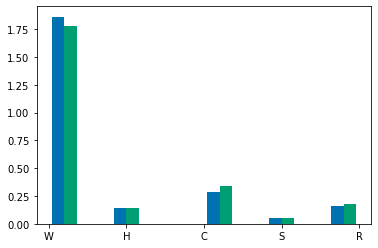

In [28]:
plt.hist([X_train.ProductCD,X_test.ProductCD],density=True)

([array([1.8894472 , 0.        , 0.13796837, 0.        , 0.        ,
         0.26545641, 0.        , 0.04800159, 0.        , 0.15912644]),
  array([1.0851522 , 0.        , 0.19043701, 0.        , 0.        ,
         0.96888158, 0.        , 0.0829986 , 0.        , 0.17253061])],
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 Lists of Patches objects>)

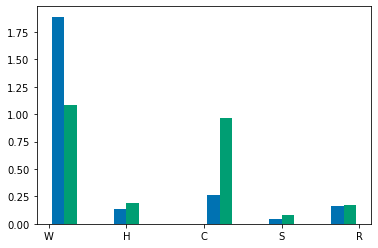

In [29]:
plt.hist([X_train.loc[X_train.isFraud==0,'ProductCD'],X_train.loc[X_train.isFraud==1,'ProductCD']],density=True)

可以看到训练集与测试集分布上差异不大，好坏客户上差异比较大，C产品的欺诈发生的情况更加严重，W产品的欺诈用户相对较少

## card1~card6
考虑到部分card类特征的基数太大无法进行hist画图，仅针对基数比较低的card特征画图

In [30]:
for col in ['card1','card2','card3','card4','card5','card6']:
    print('train  '+col+':')
    print(X_train[col].value_counts(1))
    print('\n')
    print('test  '+col+':')
    print(X_test[col].value_counts(1))
    print('==================================================================================================================')

train  card1:
7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
           ...   
12390    0.000002
10341    0.000002
10006    0.000002
15743    0.000002
17105    0.000002
Name: card1, Length: 13553, dtype: float64


test  card1:
7919     0.025820
15885    0.024334
9500     0.023843
17188    0.018279
15066    0.013146
           ...   
1667     0.000002
8516     0.000002
2369     0.000002
1754     0.000002
18392    0.000002
Name: card1, Length: 13244, dtype: float64
train  card2:
321.0    0.084138
111.0    0.077700
555.0    0.072205
490.0    0.065586
583.0    0.037488
           ...   
447.0    0.000067
153.0    0.000065
557.0    0.000064
473.0    0.000031
582.0    0.000024
Name: card2, Length: 500, dtype: float64


test  card2:
321.0    0.085929
555.0    0.077121
111.0    0.074986
490.0    0.064957
583.0    0.039555
           ...   
240.0    0.000068
487.0    0.000060
234.0    0.000048
480.0    0.000014
586.0    0.000002
Name: card2, Length: 49

### card1
可以看到card1是一个高基数类别特征，一般来说都是需要进行编码的（lgb和catboost底层实际上也是做了编码，一个gs编码一个ts编码）；这里我们选择进行woe、targetencoding和频率编码，记录一下；


In [31]:
X_train.card1.unique().shape[0]  #类别太多，可视化也比较麻烦，算了

13553

In [32]:
X_train.card1.value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dtype: int64

In [33]:
X_test.card1.value_counts()

7919     13083
15885    12330
9500     12081
17188     9262
15066     6661
         ...  
1667         1
8516         1
2369         1
1754         1
18392        1
Name: card1, Length: 13244, dtype: int64

In [34]:
len(set(X_test.card1.dropna())-set(X_train.card1.dropna()))

3538

In [35]:
unseen=list(set(X_test.card1)-set(X_train.card1))
if_unseen=X_test.card1.apply(lambda x: x in unseen)
sum(if_unseen)

9360

X_test的card1中存在3538个未见的类别,一共有9360个样本属于未见的类别

### card2
处理方法同card1

In [36]:
X_train.card2.unique().shape[0]

501

In [37]:
X_train.card2.value_counts()

321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
447.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: card2, Length: 500, dtype: int64

In [38]:
X_test.card2.value_counts()

321.0    42796
555.0    38409
111.0    37346
490.0    32351
583.0    19700
         ...  
240.0       34
487.0       30
234.0       24
480.0        7
586.0        1
Name: card2, Length: 497, dtype: int64

In [39]:
len(set(X_test.card2.dropna())-set(X_train.card2.dropna()))

1

In [40]:
unseen=list(set(X_test.card2)-set(X_train.card2))
if_unseen=X_test.card2.apply(lambda x: x in unseen)
sum(if_unseen)

140

card2 相对于card1好多了，仅有1个unseen类别，unseen的样本一共有140个

### card3~6

In [41]:
X_train.card3.value_counts()

150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252
          ...  
228.0         1
139.0         1
114.0         1
164.0         1
221.0         1
Name: card3, Length: 114, dtype: int64

In [42]:
X_test.card3.value_counts()

150.0    435558
185.0     53614
106.0      1972
117.0      1879
144.0      1381
          ...  
174.0         1
186.0         1
175.0         1
183.0         1
110.0         1
Name: card3, Length: 115, dtype: int64

In [43]:
len(set(X_test.card3.dropna())-set(X_train.card3.dropna()))

19

In [44]:
unseen=list(set(X_test.card3)-set(X_train.card3))
if_unseen=X_test.card3.apply(lambda x: x in unseen)
sum(if_unseen)

46

card3 有19个unseen类别，unseen的样本一共有46个

In [45]:
X_train.card4.value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [46]:
X_test.card4.value_counts()

visa                334882
mastercard          158169
american express      7681
discover              2873
Name: card4, dtype: int64

In [47]:
len(set(X_test.card3.dropna())-set(X_train.card3.dropna()))

19

In [48]:
unseen=list(set(X_test.card4)-set(X_train.card4))
if_unseen=X_test.card4.apply(lambda x: x in unseen)
sum(if_unseen)

0

In [49]:
X_train.card5.value_counts()

226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
          ...  
175.0         1
173.0         1
167.0         1
234.0         1
204.0         1
Name: card5, Length: 119, dtype: int64

In [50]:
X_test.card5.value_counts()

226.0    256991
224.0     71596
166.0     45790
138.0     22102
117.0     21120
          ...  
208.0         1
125.0         1
172.0         1
167.0         1
201.0         1
Name: card5, Length: 102, dtype: int64

In [51]:
len(set(X_test.card5.dropna())-set(X_train.card5.dropna()))

19

In [52]:
unseen=list(set(X_test.card5)-set(X_train.card5))
if_unseen=X_test.card5.apply(lambda x: x in unseen)
sum(if_unseen)

54

In [53]:
X_train.card6.value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [54]:
X_test.card6.value_counts()

debit          385021
credit         118662
charge card         1
Name: card6, dtype: int64

In [55]:
len(set(X_test.card6.dropna())-set(X_train.card6.dropna()))

0

In [56]:
unseen=list(set(X_test.card6)-set(X_train.card6))
if_unseen=X_test.card6.apply(lambda x: x in unseen)
sum(if_unseen)

0

([array([0.03599365, 0.        , 0.        , 1.07166296, 0.        ,
         0.        , 2.17823455, 0.        , 0.        , 0.04744218]),
  array([0.08308279, 0.        , 0.        , 1.05001131, 0.        ,
         0.        , 2.16160734, 0.        , 0.        , 0.03863188])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 Lists of Patches objects>)

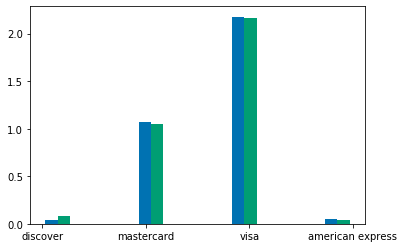

In [57]:
plt.hist([X_train.loc[X_train.isFraud==0,'card4'].dropna(),X_train.loc[X_train.isFraud==1,'card4'].dropna()],density=True)

([array([0.03764243, 0.        , 0.        , 1.07090485, 0.        ,
         0.        , 2.17765236, 0.        , 0.        , 0.04713369]),
  array([0.01901623, 0.        , 0.        , 1.04691177, 0.        ,
         0.        , 2.21656523, 0.        , 0.        , 0.05084011])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 Lists of Patches objects>)

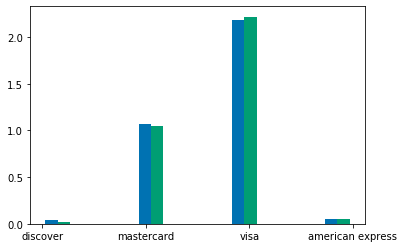

In [58]:
plt.hist([X_train.card4.dropna(),X_test.card4.dropna()],density=True)

([array([8.15443671e-01, 0.00000000e+00, 0.00000000e+00, 2.51762574e+00,
         0.00000000e+00, 0.00000000e+00, 1.75949467e-04, 0.00000000e+00,
         0.00000000e+00, 8.79747337e-05]),
  array([1.60815878, 0.        , 0.        , 1.72517455, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 Lists of Patches objects>)

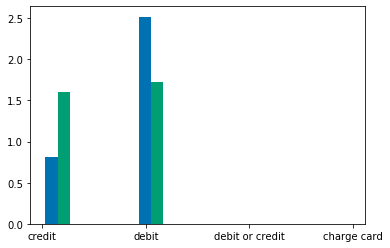

In [59]:
plt.hist([X_train.loc[X_train.isFraud==0,'card6'].dropna(),X_train.loc[X_train.isFraud==1,'card6'].dropna()],density=True)

([array([8.43202274e-01, 0.00000000e+00, 0.00000000e+00, 2.48987638e+00,
         0.00000000e+00, 0.00000000e+00, 1.69788223e-04, 0.00000000e+00,
         0.00000000e+00, 8.48941116e-05]),
  array([7.85293954e-01, 0.00000000e+00, 0.00000000e+00, 2.54803276e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 6.61790594e-06])],
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 Lists of Patches objects>)

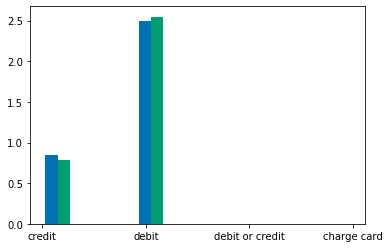

In [60]:
plt.hist([X_train.card6.dropna(),X_test.card6.dropna()],density=True)

## addr1与addr2

In [61]:
X_train.addr1.value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
462.0        1
128.0        1
481.0        1
120.0        1
340.0        1
Name: addr1, Length: 332, dtype: int64

In [62]:
X_test.addr1.value_counts()

299.0    38710
204.0    35049
325.0    34151
264.0    32710
330.0    22100
         ...  
175.0        1
113.0        1
438.0        1
464.0        1
383.0        1
Name: addr1, Length: 292, dtype: int64

In [63]:
len(set(X_test.addr1.dropna())-set(X_train.addr1.dropna()))

109

In [64]:
unseen=list(set(X_test.addr1.dropna())-set(X_train.addr1.dropna()))
if_unseen=X_test.addr1.dropna().apply(lambda x: x in unseen)
sum(if_unseen)

176

In [65]:
X_train.addr2.value_counts()

87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
55.0         1
79.0         1
49.0         1
50.0         1
70.0         1
Name: addr2, Length: 74, dtype: int64

In [66]:
X_test.addr2.value_counts()

87.0    435934
60.0      4041
96.0       608
32.0        61
65.0        49
         ...  
80.0         1
85.0         1
18.0         1
42.0         1
77.0         1
Name: addr2, Length: 72, dtype: int64

In [67]:
len(set(X_test.addr2.dropna())-set(X_train.addr2.dropna()))

19

In [68]:
unseen=list(set(X_test.addr2.dropna())-set(X_train.addr2.dropna()))
if_unseen=X_test.addr2.dropna().apply(lambda x: x in unseen)
sum(if_unseen)

47

##  dist1 和 dist2

([array([2.29613e+05, 6.32600e+03, 2.07000e+03, 1.27000e+02, 1.21000e+02,
         1.00000e+00, 8.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
  array([2.10199e+05, 3.94900e+03, 1.08200e+03, 1.37000e+02, 1.04000e+02,
         0.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00])],
 array([    0. ,  1028.6,  2057.2,  3085.8,  4114.4,  5143. ,  6171.6,
         7200.2,  8228.8,  9257.4, 10286. ]),
 <a list of 2 Lists of Patches objects>)

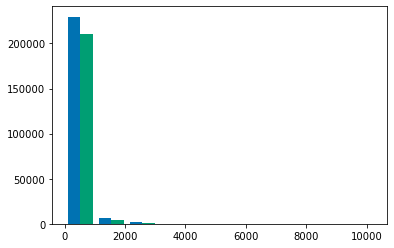

In [69]:
plt.hist([X_train.dist1,X_test.dist1])

([array([3.5933e+04, 1.2750e+03, 2.8300e+02, 4.4000e+01, 4.3000e+01,
         3.0000e+01, 1.3000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
  array([3.4731e+04, 1.2210e+03, 3.3400e+02, 3.1000e+01, 6.8000e+01,
         2.1000e+01, 2.4000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00])],
 array([    0. ,  1162.3,  2324.6,  3486.9,  4649.2,  5811.5,  6973.8,
         8136.1,  9298.4, 10460.7, 11623. ]),
 <a list of 2 Lists of Patches objects>)

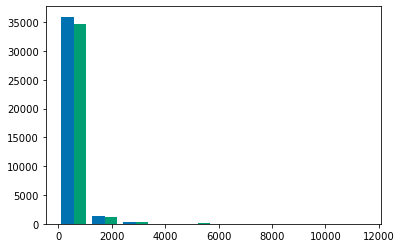

In [71]:
plt.hist([X_train.dist2,X_test.dist2])

## P_emaildomain和R_emaildomain

In [73]:
X_train.P_emaildomain.value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
twc.com                230
n

In [74]:
X_test.P_emaildomain.value_counts()

gmail.com           207448
yahoo.com            81850
hotmail.com          40399
anonymous.com        34064
aol.com              24048
comcast.net           6586
icloud.com            6049
outlook.com           4838
att.net               3614
msn.com               3388
sbcglobal.net         2797
live.com              2679
verizon.net           2306
ymail.com             1679
bellsouth.net         1528
yahoo.com.mx          1284
cox.net               1264
me.com                1191
optonline.net          926
live.com.mx            721
charter.net            627
mail.com               597
gmail                  497
earthlink.net          465
rocketmail.com         441
mac.com                426
outlook.es             425
hotmail.fr             379
hotmail.es             322
frontier.com           314
roadrunner.com         278
web.de                 278
juno.com               252
windstream.net         247
hotmail.co.uk          222
twc.com                209
embarqmail.com         204
f

In [75]:
len(set(X_test.P_emaildomain.dropna())-set(X_train.P_emaildomain.dropna()))

1

In [76]:
unseen=list(set(X_test.P_emaildomain.dropna())-set(X_train.P_emaildomain.dropna()))
if_unseen=X_test.P_emaildomain.apply(lambda x: x in unseen)
sum(if_unseen)

2

In [77]:
X_train.R_emaildomain.value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [78]:
X_test.R_emaildomain.value_counts()

gmail.com           61738
hotmail.com         25657
anonymous.com       19115
yahoo.com            9563
aol.com              3538
outlook.com          2504
comcast.net          1701
icloud.com           1422
yahoo.com.mx         1235
msn.com               846
live.com.mx           710
live.com              682
sbcglobal.net         611
verizon.net           582
me.com                539
att.net               440
outlook.es            420
cox.net               395
hotmail.fr            374
bellsouth.net         373
hotmail.es            303
web.de                277
mail.com              219
mac.com               212
hotmail.co.uk         212
ymail.com             198
yahoo.fr              178
optonline.net         163
gmx.de                150
charter.net           136
gmail                 101
prodigy.net.mx         96
earthlink.net          91
hotmail.de             88
embarqmail.com         72
yahoo.co.jp            71
yahoo.es               67
yahoo.de               64
juno.com    

In [79]:
len(set(X_test.R_emaildomain.dropna())-set(X_train.R_emaildomain.dropna()))

0

In [80]:
unseen=list(set(X_test.R_emaildomain.dropna())-set(X_train.R_emaildomain.dropna()))
if_unseen=X_test.R_emaildomain.dropna().apply(lambda x: x in unseen)
sum(if_unseen)

0

## C1~C14

In [81]:
C=[ 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7','C8','C9', 'C10', 'C11', 'C12', 'C13', 'C14',]

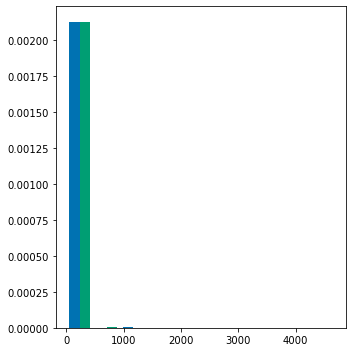

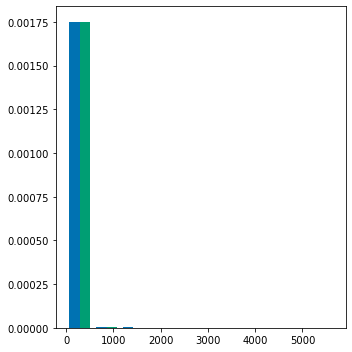

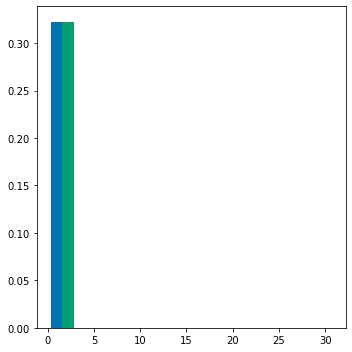

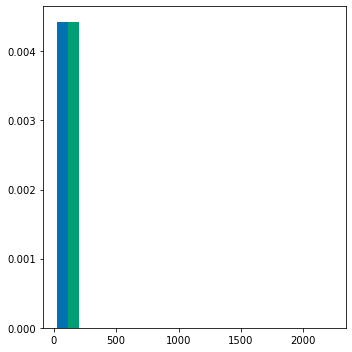

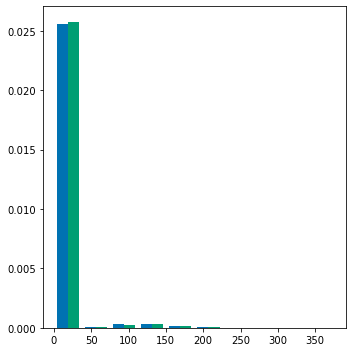

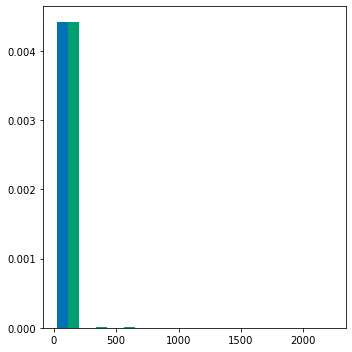

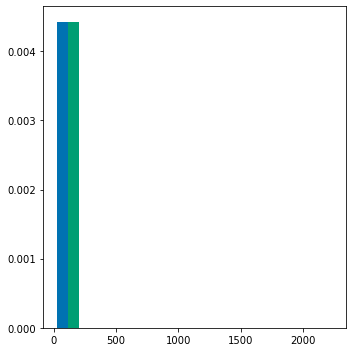

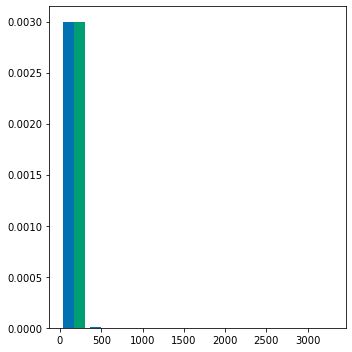

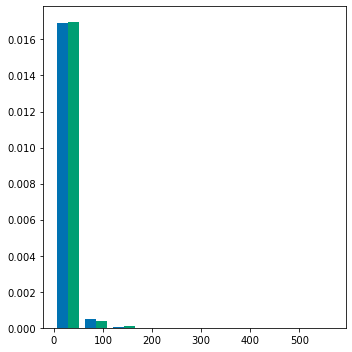

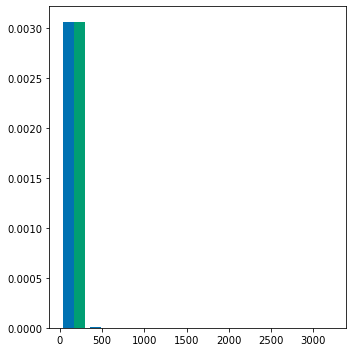

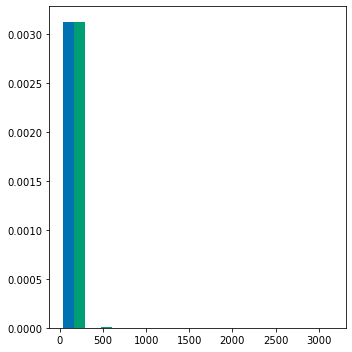

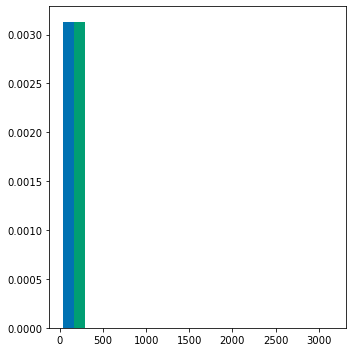

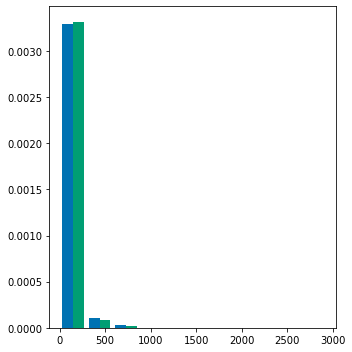

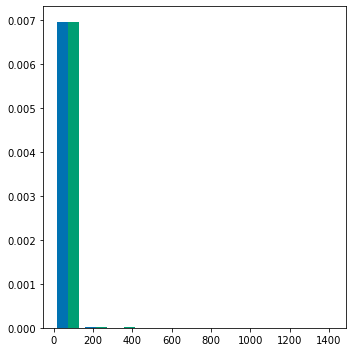

In [82]:
for i,col in enumerate(C):
    plt.figure(i,figsize=(5,5))
    plt.hist([X_train[col],X_test[col]],density=True)
    plt.tight_layout()
    plt.show()

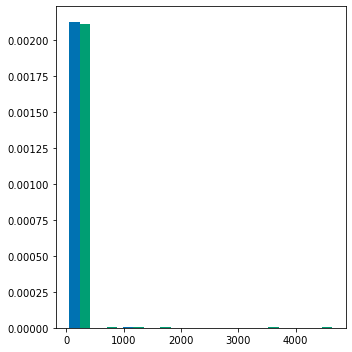

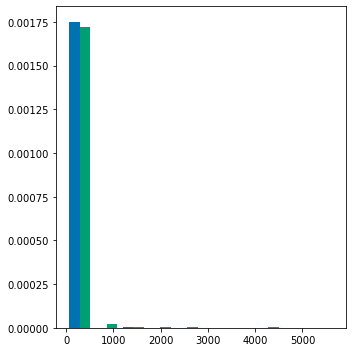

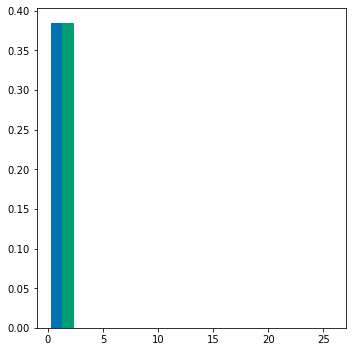

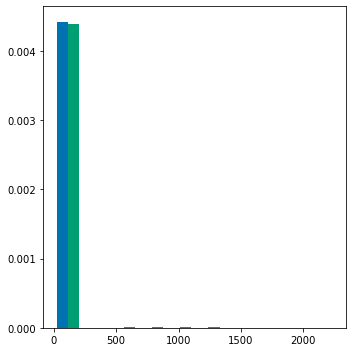

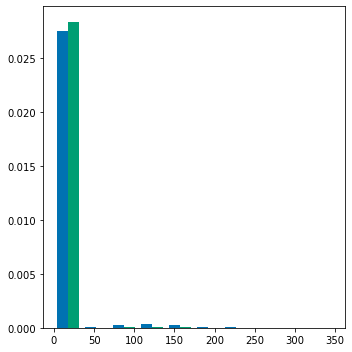

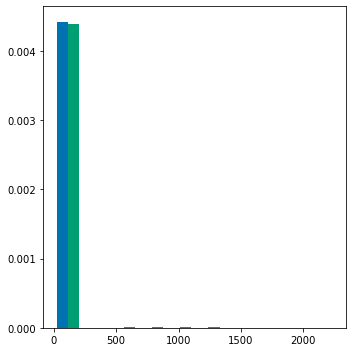

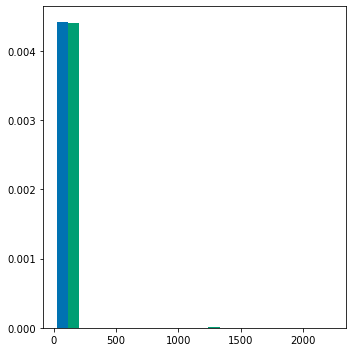

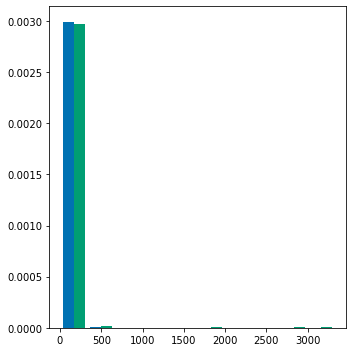

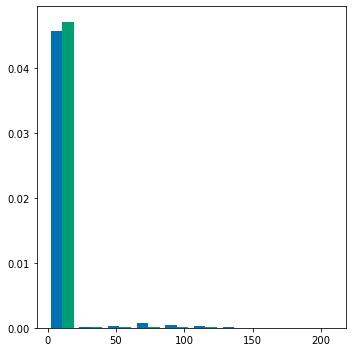

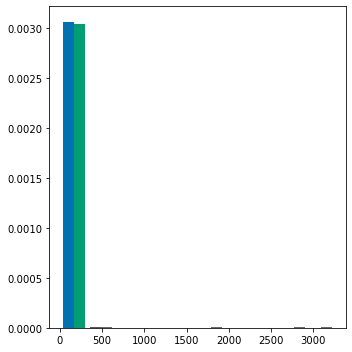

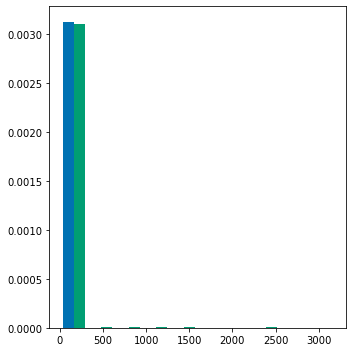

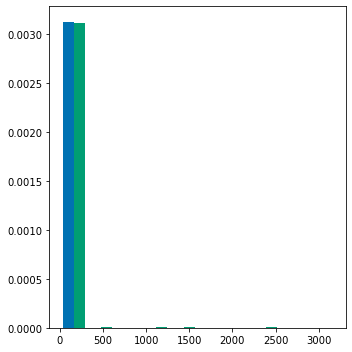

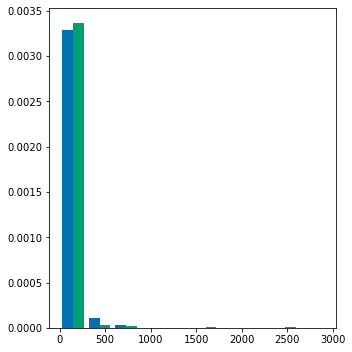

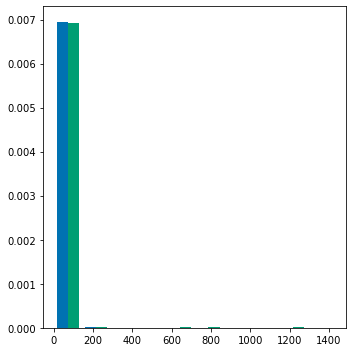

In [83]:
for i,col in enumerate(C):
    plt.figure(i,figsize=(5,5))
    plt.hist([X_train.loc[X_train.isFraud==0,col],X_train.loc[X_train.isFraud==1,col]],density=True)
    plt.tight_layout()
    plt.show()

C属于计数特征，包括了信用卡关联地址数等等，整体上看，分布差异不太大，好坏客户区分度不是很高

## D1~D15

In [84]:
D=[ 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',]

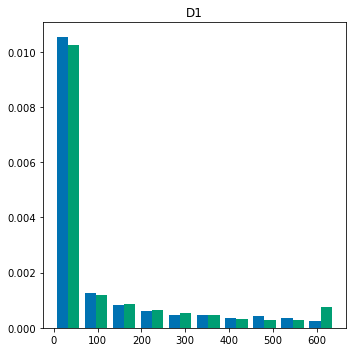

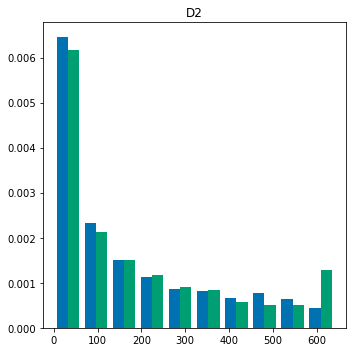

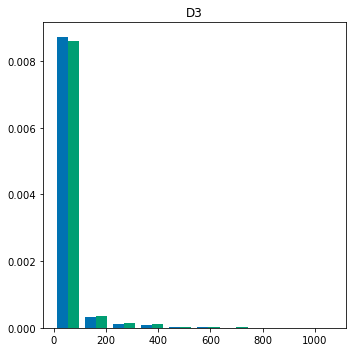

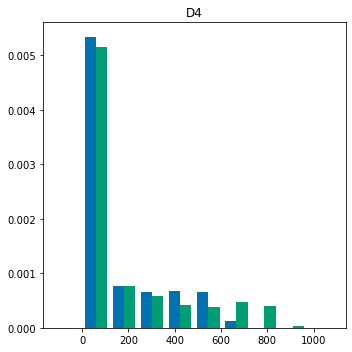

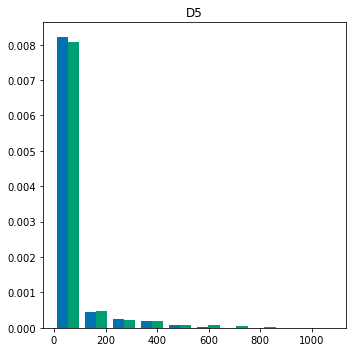

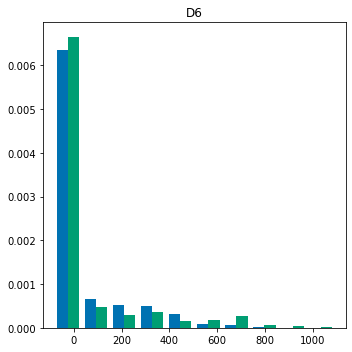

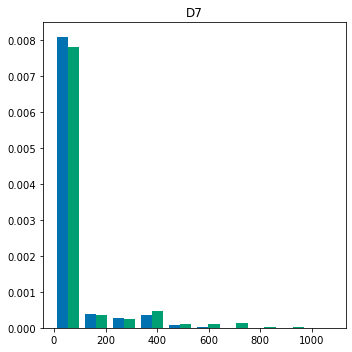

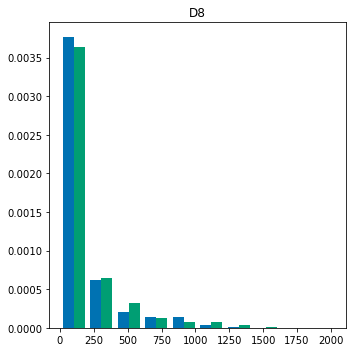

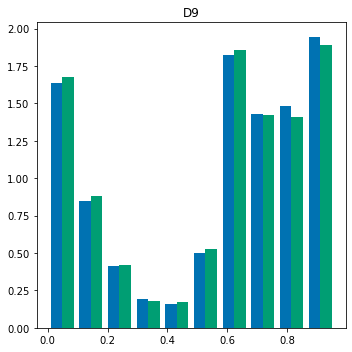

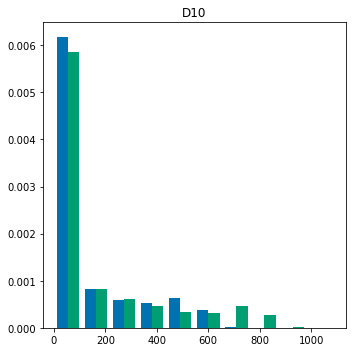

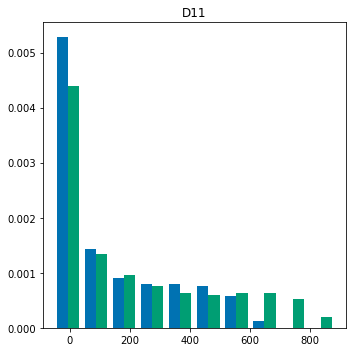

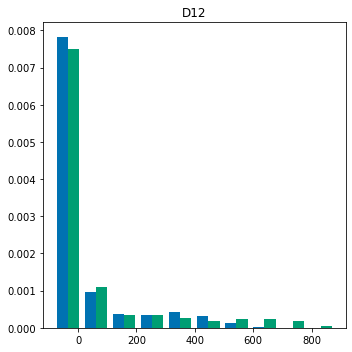

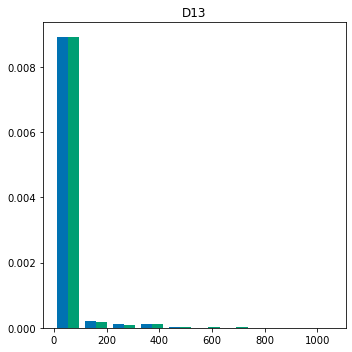

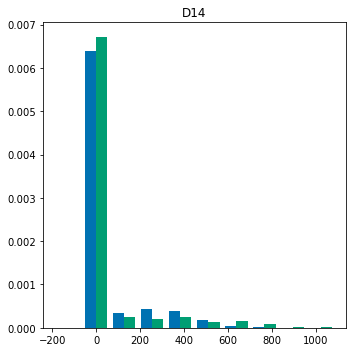

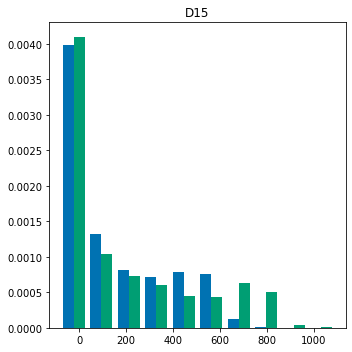

In [85]:
for i,col in enumerate(D):
    plt.figure(i,figsize=(5,5))
    plt.hist([X_train[col],X_test[col]],density=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

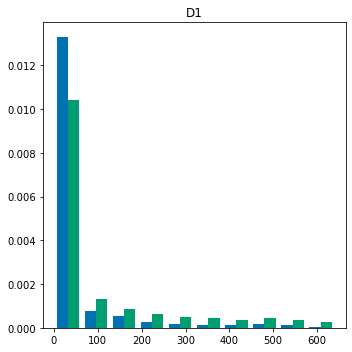

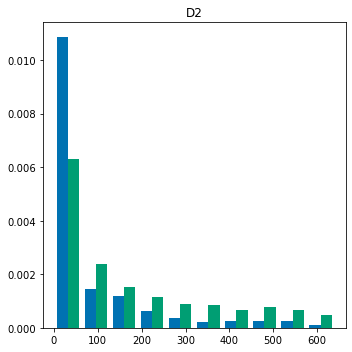

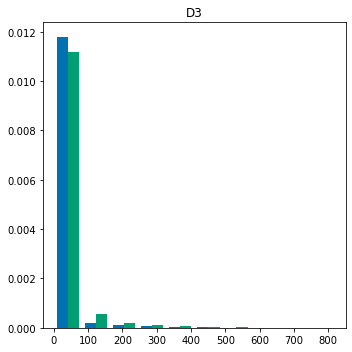

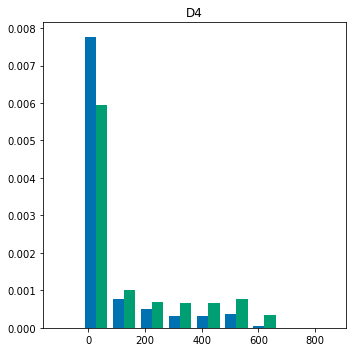

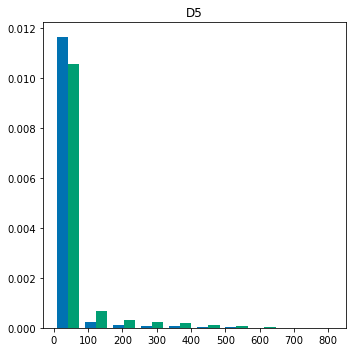

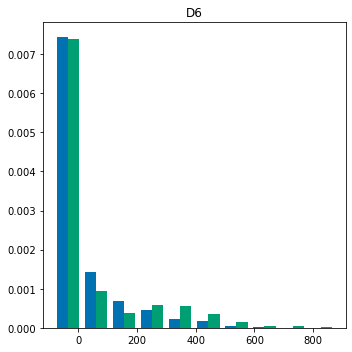

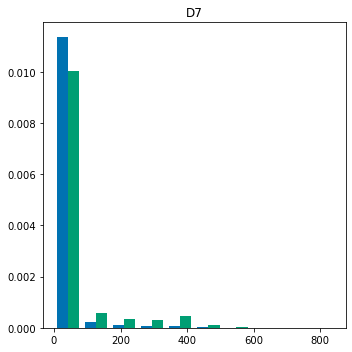

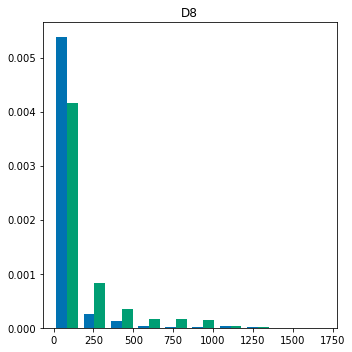

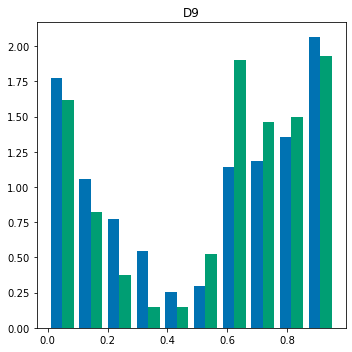

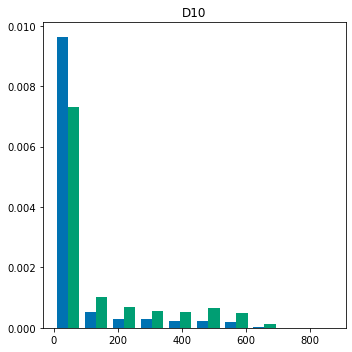

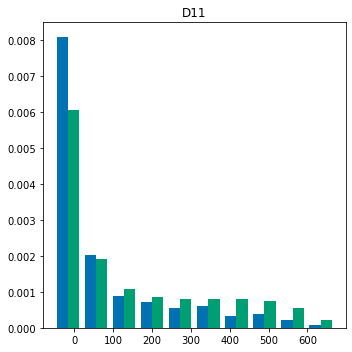

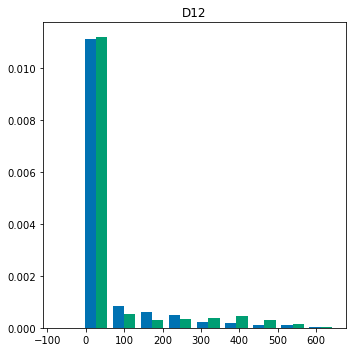

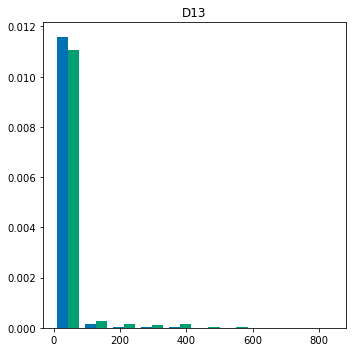

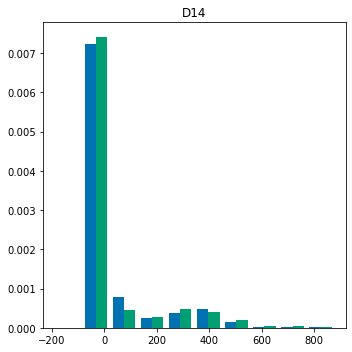

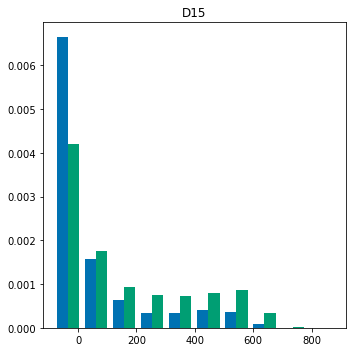

In [86]:
for i,col in enumerate(D):
    plt.figure(i,figsize=(5,5))
    plt.hist([X_train.loc[X_train.isFraud==1,col],X_train.loc[X_train.isFraud==0,col]],density=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

D系列特征包含了time delta相关的特征，在训练测试集分布上以及好坏客户的分布差异上是比较大的

## M1~M9

M系列特征都是低基数类特征，不需要太多额外的处理

In [87]:
for col in ['M'+str(item) for item in range(1,10)]:
    print(col+':')
    print(X_train[col].value_counts())
    print('\n')

M1:
T    319415
F        25
Name: M1, dtype: int64


M2:
T    285468
F     33972
Name: M2, dtype: int64


M3:
T    251731
F     67709
Name: M3, dtype: int64


M4:
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64


M5:
F    132491
T    107567
Name: M5, dtype: int64


M6:
F    227856
T    193324
Name: M6, dtype: int64


M7:
F    211374
T     32901
Name: M7, dtype: int64


M8:
F    155251
T     89037
Name: M8, dtype: int64


M9:
T    205656
F     38632
Name: M9, dtype: int64




In [88]:
for col in ['M'+str(item) for item in range(1,10)]:
    print(col+':')
    print(X_test[col].value_counts())
    print('\n')

M1:
T    330021
F        31
Name: M1, dtype: int64


M2:
T    302855
F     27197
Name: M2, dtype: int64


M3:
T    266513
F     63539
Name: M3, dtype: int64


M4:
M0    161384
M2     63082
M1     44480
Name: M4, dtype: int64


M5:
F    107664
T     89395
Name: M5, dtype: int64


M6:
F    191577
T    156175
Name: M6, dtype: int64


M7:
F    233230
T     38443
Name: M7, dtype: int64


M8:
F    168399
T    103288
Name: M8, dtype: int64


M9:
T    236279
F     35408
Name: M9, dtype: int64




In [89]:
for col in ['M'+str(item) for item in range(1,10)]:
    print(col+':')
    print(X_train[X_train.isFraud==1][col].value_counts())
    print('\n')

M1:
T    6342
Name: M1, dtype: int64


M2:
T    5158
F    1184
Name: M2, dtype: int64


M3:
T    4293
F    2049
Name: M3, dtype: int64


M4:
M0    7198
M2    6809
M1    1429
Name: M4, dtype: int64


M5:
T    4055
F    3514
Name: M5, dtype: int64


M6:
F    5397
T    3295
Name: M6, dtype: int64


M7:
F    4089
T     728
Name: M7, dtype: int64


M8:
F    3373
T    1444
Name: M8, dtype: int64


M9:
T    3658
F    1159
Name: M9, dtype: int64




In [90]:
for col in ['M'+str(item) for item in range(1,10)]:
    print(col+':')
    print(X_train[X_train.isFraud==0][col].value_counts())
    print('\n')

M1:
T    313073
F        25
Name: M1, dtype: int64


M2:
T    280310
F     32788
Name: M2, dtype: int64


M3:
T    247438
F     65660
Name: M3, dtype: int64


M4:
M0    189207
M2     53056
M1     51397
Name: M4, dtype: int64


M5:
F    128977
T    103512
Name: M5, dtype: int64


M6:
F    222459
T    190029
Name: M6, dtype: int64


M7:
F    207285
T     32173
Name: M7, dtype: int64


M8:
F    151878
T     87593
Name: M8, dtype: int64


M9:
T    201998
F     37473
Name: M9, dtype: int64




## V系列特征太多，后面进行缺失值和相关性特征处理之后再重新考虑

## id_01~id_11

In [91]:
ids=[ 'id_01','id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08','id_09', 'id_10', 'id_11']

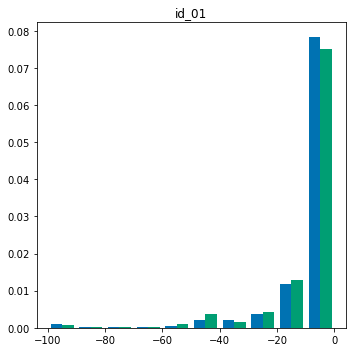

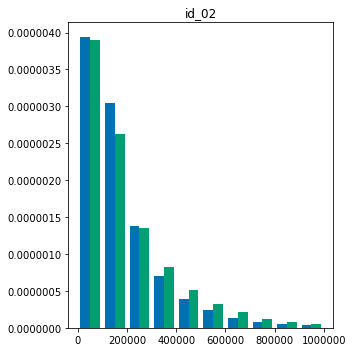

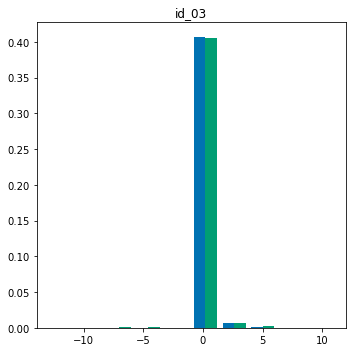

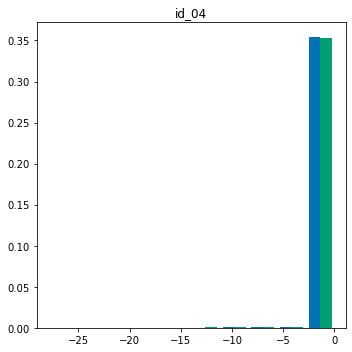

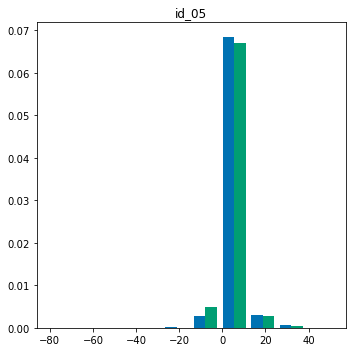

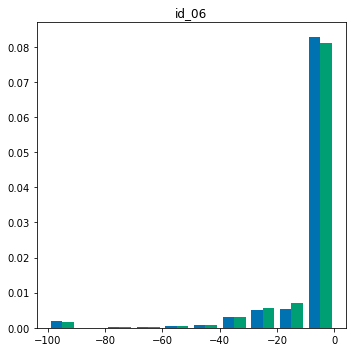

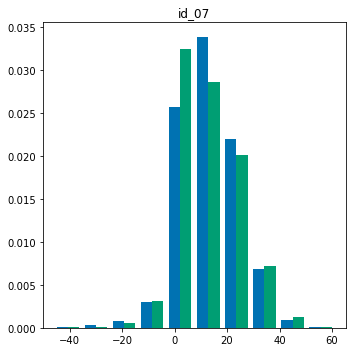

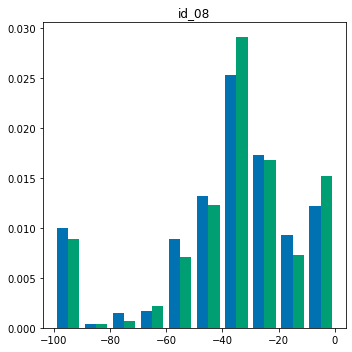

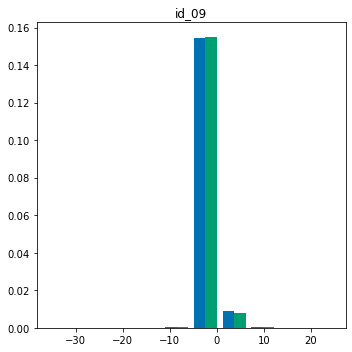

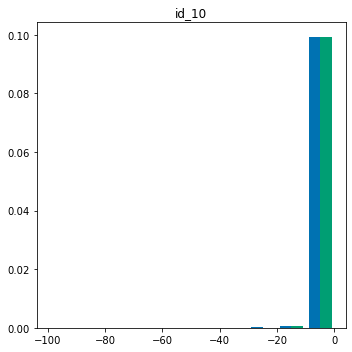

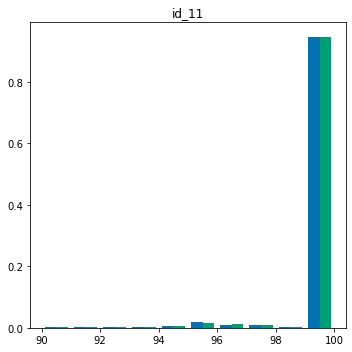

In [92]:
for i,col in enumerate(ids):
    plt.figure(i,figsize=(5,5))
    plt.hist([X_train[col],X_test[col]],density=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

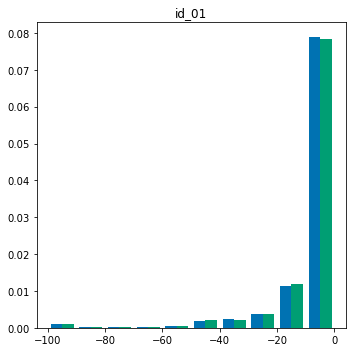

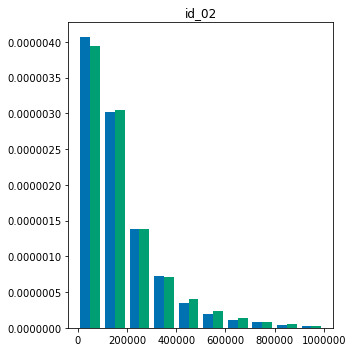

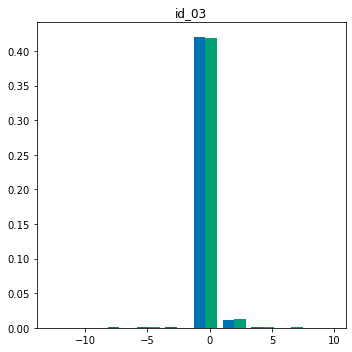

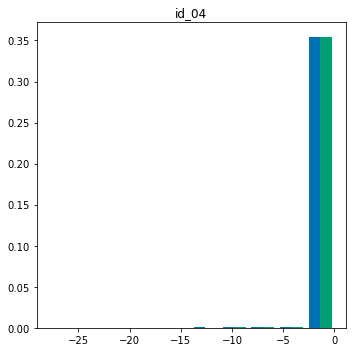

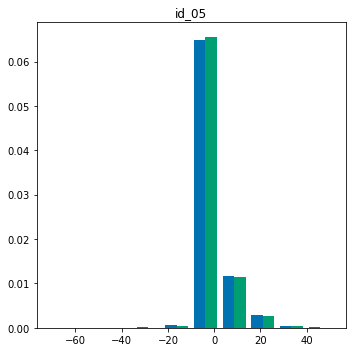

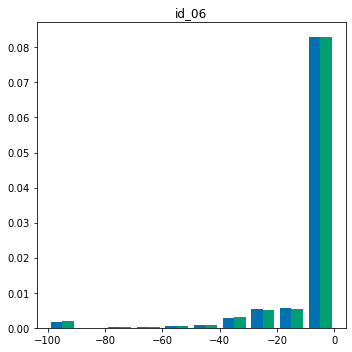

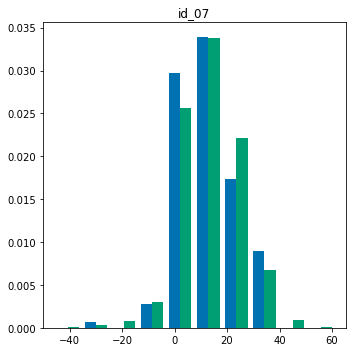

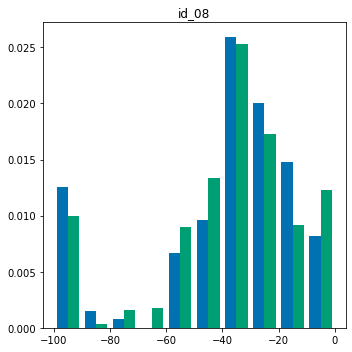

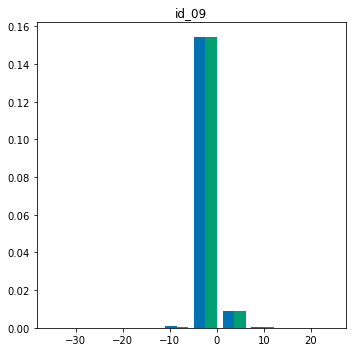

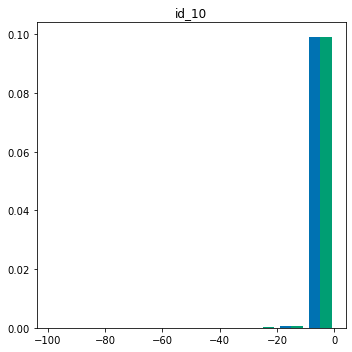

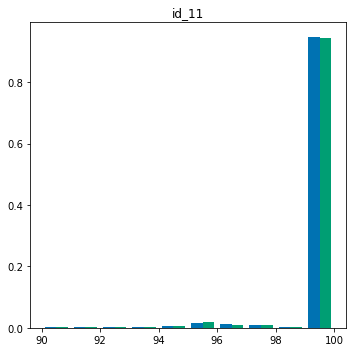

In [93]:
for i,col in enumerate(ids):
    plt.figure(i,figsize=(5,5))
    plt.hist([X_train.loc[X_train.isFraud==1,col],X_train.loc[X_train.isFraud==0,col]],density=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

部分id特征在分布和好坏客户的分布差异上比较大

## id_12~id_38

In [94]:
for col in ['id_'+str(item) for item in range(12,39)]:
    print(col+':')
    print(X_train[col].value_counts())
    print('\n')

id_12:
NotFound    123025
Found        21208
Name: id_12, dtype: int64


id_13:
52.0    58099
49.0    26365
64.0    14429
33.0    10048
27.0     3666
20.0     2878
14.0     2499
63.0     1468
19.0     1147
25.0     1066
43.0      842
62.0      813
18.0      688
41.0      654
55.0      523
11.0      373
15.0      372
24.0      318
35.0      317
51.0      196
61.0      108
44.0       85
54.0       67
28.0       59
39.0       34
31.0       29
45.0       26
38.0       22
13.0       21
58.0       17
36.0       15
48.0       10
32.0       10
56.0        9
30.0        7
22.0        5
53.0        4
17.0        3
21.0        3
57.0        3
46.0        3
47.0        3
60.0        3
12.0        2
26.0        2
59.0        1
50.0        1
10.0        1
23.0        1
37.0        1
29.0        1
34.0        1
40.0        1
42.0        1
Name: id_13, dtype: int64


id_14:
-300.0    44121
-360.0    16661
-480.0    12891
-420.0     4542
-600.0      498
 60.0       369
 0.0        192
-240.0      159
-

In [95]:
for col in ['id_'+str(item) for item in range(12,39)]:
    print(col+':')
    print(X_test[col].value_counts())
    print('\n')

id_12:
NotFound    120895
Found        21012
Name: id_12, dtype: int64


id_13:
27.0    69616
52.0    51661
14.0     3928
62.0      939
20.0      926
63.0      582
18.0      530
11.0      517
41.0      432
55.0      258
25.0      236
24.0      213
51.0      153
15.0      148
43.0       65
28.0       18
39.0       11
36.0       10
56.0       10
31.0        9
42.0        8
21.0        5
16.0        3
44.0        2
30.0        2
37.0        2
48.0        2
Name: id_13, dtype: int64


id_14:
-300.0    39612
-360.0    14535
-480.0    11354
-420.0     4209
-600.0      512
 60.0       318
 0.0        172
-240.0      138
-540.0       84
-180.0       78
 480.0       58
 120.0       57
 540.0       54
 600.0       51
 420.0       37
 180.0       36
 240.0       11
 720.0        9
 300.0        8
 330.0        6
 270.0        5
-210.0        4
 570.0        4
 360.0        2
 660.0        1
-120.0        1
-720.0        1
Name: id_14, dtype: int64


id_15:
Found      67962
New        57785
Unknow

可以看到，部分id带有比较详细的文本信息，一般来说，这类文本信息相对于数字更容易基于先验知识做一些特征衍生的工作

##  DeviceType DeviceInfo had_id

In [96]:
for col in ['DeviceType','DeviceInfo','had_id']:
    print(col+':')
    print(X_train[col].value_counts())
    print('\n')

DeviceType:
desktop    85165
mobile     55645
Name: DeviceType, dtype: int64


DeviceInfo:
Windows              47722
iOS Device           19782
MacOS                12573
Trident/7.0           7440
rv:11.0               1901
                     ...  
AOC_U706G                1
Azumi_KINZO_A5_QL        1
LG-H221                  1
LG-D851                  1
LG-D725                  1
Name: DeviceInfo, Length: 1786, dtype: int64


had_id:
1.0    144233
Name: had_id, dtype: int64




In [97]:
1-144233/X_train.shape[0]

0.7557608290716971

In [98]:
for col in ['DeviceType','DeviceInfo','had_id']:
    print(col+':')
    print(X_test[col].value_counts())
    print('\n')

DeviceType:
desktop    74403
mobile     62528
Name: DeviceType, dtype: int64


DeviceInfo:
Windows        44988
iOS Device     18720
MacOS          11149
Trident/7.0     4890
rv:11.0          749
               ...  
E2306              1
BV8000Pro          1
BAH-L09            1
BV7000             1
G3121              1
Name: DeviceInfo, Length: 2226, dtype: int64


had_id:
1.0    141907
Name: had_id, dtype: int64




In [99]:
1-141907/X_test.shape[0]

0.7199338452824305

device相关的特征包含有较为详细的设备信息，可以做一些特征衍生的工作

同时根据had_id的样本占比可知，能和附表关联上的主表的样本基本在附表的特征上得缺失70%~75%，所以我们后续进行缺失特征处理的时候需要注意，缺失阈值不要切分的太过严格，否则会切掉太多的附表特征

# 合并之后的数据保存

In [100]:
X_train.to_csv('X.csv',index=False)
X_test.to_csv('X_test.csv',index=False)

In [101]:
cat=pd.DataFrame(cat,columns=['cat'])
cat.to_csv('cat.csv',index=False)